In [140]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import time
import os

In [141]:
class Network(nn.Module):
    def __init__(self,num_input=2,layers=[128, 128, 128, 128],num_output=3):
        super(Network,self).__init__()
        self.input_layer=nn.Linear(num_input,layers[0])
        self.hidden_layer=nn.ModuleList()
        for i in range(len(layers)-1):
            self.hidden_layer.append(nn.Linear(layers[i],layers[i+1]))
        self.output_layer=nn.Linear(layers[-1],num_output)
    def forward(self,out):
        out=torch.tanh(self.input_layer(out))
        for layer in self.hidden_layer:
            out=torch.tanh(layer(out))
        out=self.output_layer(out)
        return out

In [150]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)
        print("CUDA Available:", torch.cuda.is_available())

        # Problem parameters
        self.Re = 800.0
        self.L = 10.0
        self.H = 1.0
        self.step_height = 0.0
        self.step_length = 2.0

        # Domain_Definition
        self.nx=350.0
        self.ny=35.0
        dx=self.L/self.nx
        dy=self.H/self.ny
        self.x=torch.arange(0,self.L+dx,dx)
        self.y=torch.arange(-self.H/2.0,self.H/2.0+dy,dy)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T
        self.X.requires_grad = True

        # Boundary_condition_input
        dx_b=self.L/3500.0
        dy_b=self.H/350.0
        self.x_b = torch.arange(0,self.L+dx_b,dx_b)
        self.y_b = torch.arange(-self.H/2.0,self.H/2.0+dy_b,dy_b)
        self.lw_inlet = torch.stack(torch.meshgrid(self.x_b[0],self.y_b[len(self.y_b)//2:])).reshape(2,-1).T
        self.lw_wall = torch.stack(torch.meshgrid(self.x_b[0],self.y_b[:len(self.y_b)//2])).reshape(2,-1).T
        self.uw = torch.stack(torch.meshgrid(self.x_b,self.y_b[-1])).reshape(2,-1).T
        self.dw = torch.stack(torch.meshgrid(self.x_b,self.y_b[0])).reshape(2,-1).T
        self.X_train = torch.cat([self.lw_inlet, self.lw_wall, self.uw,  self.dw])


        # Boundary_condition_output
        y1 = self.y_b[len(self.y_b)//2:]
        y2 = self.y_b[:len(self.y_b)//2]
        self.u_profile = 24 * y1 * (0.5 - y1)
        self.uv_lw_inlet = torch.stack(torch.meshgrid(self.u_profile,self.x_b[0])).reshape(2,-1).T
        self.uv_lw_wall = torch.stack(torch.meshgrid(torch.zeros_like(y2),self.x_b[0])).reshape(2,-1).T
        self.uv_uw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.x_b))).reshape(2,-1).T
        self.uv_dw = torch.stack(torch.meshgrid(self.x_b[0],torch.zeros_like(self.x_b))).reshape(2,-1).T
        self.uv_train = torch.cat([self.uv_lw_inlet, self.uv_lw_wall, self.uv_uw,  self.uv_dw])
        # Transfer tensor to GPU
        self.uv_train = self.uv_train.to(self.device)
        self.X_train = self.X_train.to(self.device)
        self.X = self.X.to(self.device)

        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters(), lr=1e-4)
        # , lr=1e-4
        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=0.01,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-8,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        self.loss_history = []

        
    #compute derivations
    def gradient(self,input,index):
        output = torch.autograd.grad(
            input,
            self.X,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True
        )[0]
        return output[:,index]

    def loss_f(self):
        #Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        #output of NN for boundary
        self.uv_P_b = self.network(self.X_train)
        self.u_P_b = self.uv_P_b[:,0]
        self.v_P_b = self.uv_P_b[:,1]

        #loss data definition
        self.loss_data = self.criterion(self.u_P_b,self.uv_train[:,0])+self.criterion(self.v_P_b,self.uv_train[:,1])

        #output of NN
        self.uvp_P = self.network(self.X)
        self.u_P = self.uvp_P[:,0]
        self.v_P = self.uvp_P[:,1]
        self.p_P = self.uvp_P[:,2]

        #compute derivations
        self.du_dx = self.gradient(self.u_P,0)
        self.du_dy = self.gradient(self.u_P,1)
        self.du_dxx= self.gradient(self.du_dx,0)
        self.du_dyy= self.gradient(self.du_dy,1)
        self.dv_dx = self.gradient(self.v_P,0)
        self.dv_dy = self.gradient(self.v_P,1)
        self.dv_dxx= self.gradient(self.dv_dx,0)
        self.dv_dyy= self.gradient(self.dv_dy,1)
        self.dp_dx = self.gradient(self.p_P,0)
        self.dp_dy = self.gradient(self.p_P,1)

        # Navier-Stokes equations residuals
        continuity = self.du_dx + self.dv_dy
        momentum_x = self.u_P * self.du_dx + self.v_P * self.du_dy + self.dp_dx - (1/self.Re) * (self.du_dxx + self.du_dyy)
        momentum_y = self.u_P * self.dv_dx + self.v_P * self.dv_dy + self.dp_dy - (1/self.Re) * (self.dv_dxx + self.dv_dyy)

        # Only PDE loss (no BC loss since we use hard BC)

        self.loss_pde = self.criterion(continuity, torch.zeros_like(continuity)) + \
                self.criterion(momentum_x, torch.zeros_like(momentum_x)) + \
                self.criterion(momentum_y, torch.zeros_like(momentum_y))

        #loss function definition
        lambda_bc = 1.0
        lambda_pde = 1.0
        self.loss = lambda_bc * self.loss_data + lambda_pde * self.loss_pde
        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            self.loss_history.append(loss.item())
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.9f}")
            if i % 100 == 0:
                torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/Backward-facing step/Ra=800/1-PINNs/model')
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
        torch.save(self.network.state_dict(), r'C:/Users/hossein/Result/Backward-facing step/Ra=800/1-PINNs/model')
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.p = self.uvp_P[:,2].reshape(len(self.x), len(self.y)).cpu().numpy().T

        plt.rcParams.update({
            "font.family": "Times New Roman",
            "font.style": "italic"
        })

        plt.figure(figsize=(12, 3))
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        cbar = plt.colorbar(contour1, orientation='horizontal', pad=0.2, aspect=60, location='top')
        cbar.ax.set_title('u-velocity', fontsize=14, pad=10)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        cbar.ax.xaxis.set_ticks_position('bottom')
        plt.xlabel("x ", fontsize=14)
        plt.ylabel("y ", fontsize=14)
        plt.savefig("C:/Users/hossein/Result/Backward-facing step/Ra=800/1-PINNs/u_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(12, 3))
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        cbar = plt.colorbar(contour2, orientation='horizontal', pad=0.2, aspect=60, location='top')
        cbar.ax.set_title('v-velocity', fontsize=14, pad=10)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        cbar.ax.xaxis.set_ticks_position('bottom')
        plt.xlabel("x ", fontsize=14)
        plt.ylabel("y ", fontsize=14)
        plt.savefig("C:/Users/hossein/Result/Backward-facing step/Ra=800/1-PINNs/v_plot.png", dpi=300)
        plt.show()
        plt.close()

        plt.figure(figsize=(12, 3))
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.p, levels=50, cmap="jet")
        cbar = plt.colorbar(contour3, orientation='horizontal', pad=0.2, aspect=60, location='top')
        cbar.ax.set_title('Pressure', fontsize=14, pad=10)
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.3f"))
        cbar.ax.xaxis.set_ticks_position('bottom')
        plt.xlabel("x", fontsize=14)
        plt.ylabel("y", fontsize=14)
        plt.savefig("C:/Users/hossein/Result/Backward-facing step/Ra=800/1-PINNs/pressure_plot.png", dpi=300)
        plt.show()
        plt.close()


    def plot_loss(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Function History')
        plt.yscale("log")
        plt.grid(True)
        plt.legend()
        plt.show()
        df = pd.DataFrame({"loss": self.loss_history})
        df.to_csv("C:/Users/hossein/Result/Backward-facing step/Ra=800/1-PINNs/loss_history3.csv", index=False)

CUDA Available: True
Iteration 0, Loss: 0.000000427
Iteration 10, Loss: 0.000010422
Iteration 20, Loss: 0.000004432
Iteration 30, Loss: 0.000002277
Iteration 40, Loss: 0.000001067
Iteration 50, Loss: 0.000000612
Iteration 60, Loss: 0.000000510
Iteration 70, Loss: 0.000000462
Iteration 80, Loss: 0.000000442
Iteration 90, Loss: 0.000000434
Iteration 100, Loss: 0.000000433
Iteration 110, Loss: 0.000000431
Iteration 120, Loss: 0.000000431
Iteration 130, Loss: 0.000000430
Iteration 140, Loss: 0.000000430
Iteration 150, Loss: 0.000000429
Iteration 160, Loss: 0.000000429
Iteration 170, Loss: 0.000000429
Iteration 180, Loss: 0.000000429
Iteration 190, Loss: 0.000000429
Iteration 200, Loss: 0.000000428
Iteration 210, Loss: 0.000000428
Iteration 220, Loss: 0.000000428
Iteration 230, Loss: 0.000000428
Iteration 240, Loss: 0.000000428
Iteration 250, Loss: 0.000000428
Iteration 260, Loss: 0.000000428
Iteration 270, Loss: 0.000000428
Iteration 280, Loss: 0.000000428
Iteration 290, Loss: 0.000000427


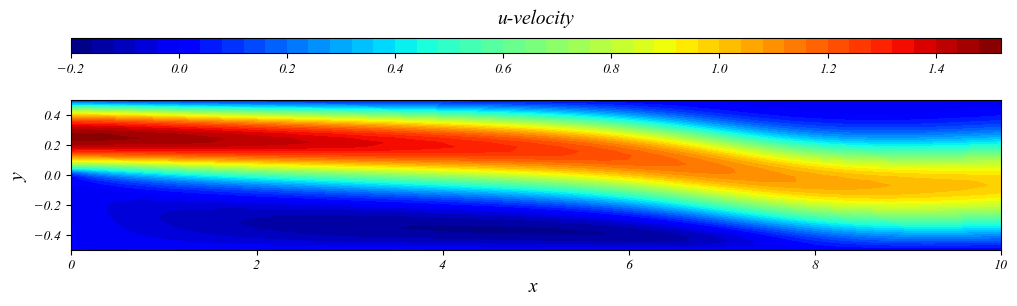

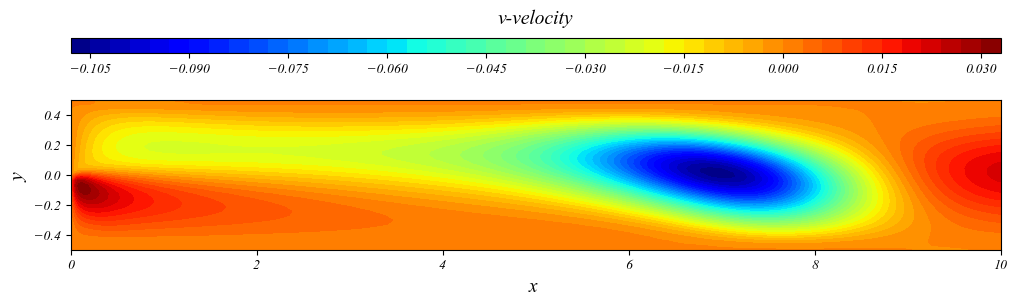

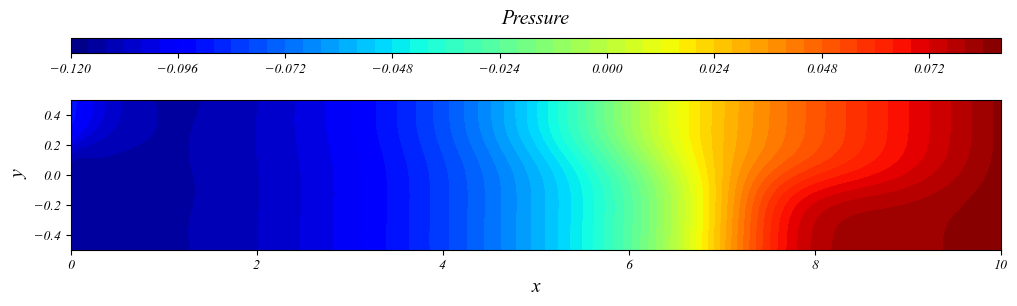

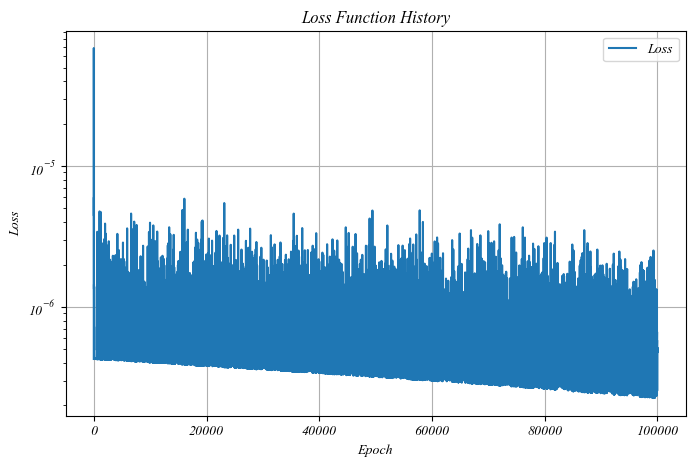

In [151]:
net = Pinns()
net.network.load_state_dict(torch.load(r'C:/Users/hossein/Result/Backward-facing step/Ra=800/1-PINNs/model'))
net.train(num_epochs=100000)
net.plot()
net.plot_loss()